<a href="https://colab.research.google.com/github/lov4jin/Plant-Pathology/blob/master/Copy_of_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SM Unet & TF DATA Set for Albumentations

In [0]:
import os
import gc
import re

import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [2]:
# Install TensorFlow
#!pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0-rc2


In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##### Define the location of image & Mask

In [5]:
IMG_DIM = 256
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant_256/img_{}/Train'.format(IMG_DIM)
val_dir = '/content/drive/My Drive/Colab Notebooks/Plant_256/img_{}/Valid'.format(IMG_DIM)

INIT_LR = 1e-3
EPOCHS = 100
BS = 32

fname_ids = []

for path, subdirs, files in os.walk(data_dir):
    for name in files:
        fname_ids.append(os.path.join(path, name))

Train_size = len(fname_ids)

f_val_name_ids = []
for path, subdirs, files in os.walk(val_dir):
    for name in files:
        f_val_name_ids.append(os.path.join(path, name))


Val_size = len(f_val_name_ids)

Train_size, Val_size


(1638, 183)

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Plant_256')

In [0]:
test_images = []


for ids in f_val_name_ids:
    test_images.append(img_to_array((load_img(ids, target_size=(IMG_DIM, IMG_DIM)))))

test_images = np.array(test_images,dtype='float32')/255

In [0]:
def display(display_list):
#     fig = plt.figure(figsize=(15, 5))
    fig = plt.figure()

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'gray')
        plt.axis('off')
    plt.show()
    return fig

In [9]:
data_gen_args = dict(
    rescale=1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_generator = image_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_DIM,IMG_DIM),
    batch_size=BS,
    class_mode=None,
    seed=seed)
mask_generator = mask_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_DIM,IMG_DIM),
    batch_size=BS,
    class_mode='categorical',
    seed=seed)


val_image_generator = val_image_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_DIM,IMG_DIM),
    batch_size=1,
    class_mode=None,
    seed=seed)
val_mask_generator = val_mask_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_DIM,IMG_DIM),
    batch_size=1,
    class_mode='categorical',
    seed=seed)

Found 1638 images belonging to 4 classes.
Found 1638 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


In [10]:
len(image_generator), len(val_image_generator)

(52, 183)

In [0]:
train_generator = zip(image_generator,mask_generator)
val_generator = zip(val_image_generator,val_mask_generator)

In [0]:
ds = tf.data.Dataset.from_generator(lambda: train_generator,
                     output_types=(tf.float32,(tf.float32,tf.float32)),
                     output_shapes=([None, IMG_DIM, IMG_DIM, 3],([None, IMG_DIM, IMG_DIM, 3],[ None, 4]))
                     )
val_ds = tf.data.Dataset.from_generator(lambda: val_generator ,
                     output_types=(tf.float32,(tf.float32,tf.float32)),
                     output_shapes=([None, IMG_DIM, IMG_DIM, 3],([None, IMG_DIM, IMG_DIM, 3],[ None, 4]))
                     )


1.0 0.0


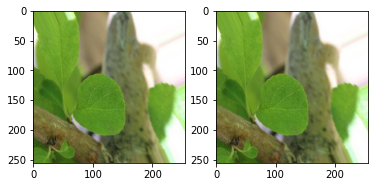

In [13]:
it = iter(ds)
batch = next(it)
batch[1][0].shape
plt.subplot(1,2,1)
plt.imshow(batch[0][7])
plt.subplot(1,2,2)
plt.imshow(batch[1][0][7])
print(np.max(batch[1][0]),np.min(batch[1][0]))

In [0]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, concatenate,Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [17]:
from keras.models import load_model

autoencoder = load_model('Autoencoder.hd5')

Using TensorFlow backend.


OSError: ignored

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = BatchNormalization()(encoder)
  encoder = Activation('relu')(encoder)
  encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = concatenate([concat_tensor, decoder], axis=-1)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  return decoder

def decoder_block2(input_tensor, num_filters):
  decoder = tf.keras.layers.UpSampling2D((2, 2))(input_tensor)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  return decoder

In [0]:
inputs =  tf.keras.Input(shape=(IMG_DIM, IMG_DIM, 3))  # adapt this if using `channels_first` image data format

# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)

# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)

volumeSize = K.int_shape(center)
center= Flatten()(center)
latent = Dense(1024,name="encoded")(center)
latent = Activation('relu')(latent)
dis_output = Dense(4, activation='softmax',name="dis_output")(latent)

# start building the decoder model which will accept the
# output of the encoder as its inputs
decode_input = Dense(np.prod(volumeSize[1:]))(latent)
decode_input = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decode_input)
# center

decoder4 = decoder_block(decode_input, encoder4, 512)
# # 16

decoder3 = decoder_block2(decoder4, 256)
# decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# decoder2 = decoder_block2(decoder3,128)
# 64

# decoder1 = decoder_block(decoder2, encoder1, 64)
decoder1 = decoder_block2(decoder2,64)
# 128
# decoder0 = decoder_block(decoder1, encoder0, 64)
decoder0 = decoder_block2(decoder1, 32)
# 256

outputs = Conv2D(3, (1, 1), activation='sigmoid',name= 'outputs')(decoder0)

In [0]:
from tensorflow.python.keras import models
autoencoder = models.Model(inputs=[inputs], outputs=[outputs,dis_output])

In [0]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss={'outputs': 'mse', 'dis_output': 'categorical_crossentropy'},
                    loss_weights={'outputs': 1, 'dis_output': 1}, optimizer=opt)



In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        if epoch % 5 == 0 :
            fig = display([sample_image, np.squeeze(autoencoder.predict(sample_image[tf.newaxis, ...])[0], axis=(0))])
#             fig.savefig('./fig/After{}.png'.format(epoch+1))
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

sample_image = test_images[0]

In [0]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=False, mode='min'),
    DisplayCallback(),
#     tf.keras.callbacks.ReduceLROnPlateau(),
]



Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 15.4566 - outputs_loss: 0.0227 - dis_output_loss: 15.4339 

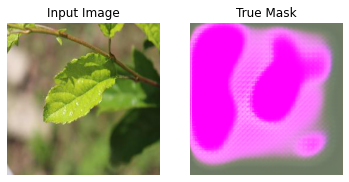


Sample Prediction after epoch 1

52/52 [==============================] - 746s 14s/step - loss: 15.4566 - outputs_loss: 0.0227 - dis_output_loss: 15.4339 - val_loss: 19.3526 - val_outputs_loss: 0.3074 - val_dis_output_loss: 19.0451
Epoch 2/100
52/52 [==============================] - 70s 1s/step - loss: 1.3465 - outputs_loss: 0.0071 - dis_output_loss: 1.3394 - val_loss: 1.9660 - val_outputs_loss: 0.1765 - val_dis_output_loss: 1.7895
Epoch 3/100
52/52 [==============================] - 70s 1s/step - loss: 1.2351 - outputs_loss: 0.0053 - dis_output_loss: 1.2298 - val_loss: 1.3102 - val_outputs_loss: 0.0374 - val_dis_output_loss: 1.2727
Epoch 4/100
52/52 [==============================] - 70s 1s/step - loss: 1.2422 - outputs_loss: 0.0057 - dis_output_loss: 1.2365 - val_loss: 1.3326 - val_outputs_loss: 0.0373 - val_dis_output_loss: 1.2954
Epoch 5/100
52/52 [==============================] - 69s 1s/step - loss: 1.2041 - outputs_loss: 0.0047 - dis_output_loss: 1.1994 - val_loss: 1.3210 - va

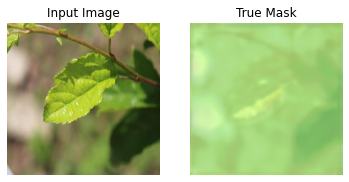


Sample Prediction after epoch 6

52/52 [==============================] - 70s 1s/step - loss: 1.1826 - outputs_loss: 0.0041 - dis_output_loss: 1.1785 - val_loss: 1.3076 - val_outputs_loss: 0.0263 - val_dis_output_loss: 1.2813
Epoch 7/100
52/52 [==============================] - 69s 1s/step - loss: 1.1976 - outputs_loss: 0.0052 - dis_output_loss: 1.1924 - val_loss: 1.3796 - val_outputs_loss: 0.0268 - val_dis_output_loss: 1.3528
Epoch 8/100
52/52 [==============================] - 69s 1s/step - loss: 1.1657 - outputs_loss: 0.0045 - dis_output_loss: 1.1611 - val_loss: 1.3179 - val_outputs_loss: 0.0189 - val_dis_output_loss: 1.2990
Epoch 9/100
52/52 [==============================] - 69s 1s/step - loss: 1.1826 - outputs_loss: 0.0041 - dis_output_loss: 1.1785 - val_loss: 1.2430 - val_outputs_loss: 0.0152 - val_dis_output_loss: 1.2278
Epoch 10/100
52/52 [==============================] - 69s 1s/step - loss: 1.1641 - outputs_loss: 0.0038 - dis_output_loss: 1.1603 - val_loss: 1.2163 - val_out

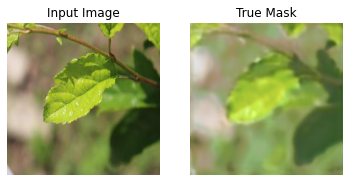


Sample Prediction after epoch 11

52/52 [==============================] - 69s 1s/step - loss: 1.1670 - outputs_loss: 0.0037 - dis_output_loss: 1.1633 - val_loss: 1.1540 - val_outputs_loss: 0.0094 - val_dis_output_loss: 1.1446
Epoch 12/100
52/52 [==============================] - 69s 1s/step - loss: 1.1851 - outputs_loss: 0.0041 - dis_output_loss: 1.1809 - val_loss: 1.2527 - val_outputs_loss: 0.0132 - val_dis_output_loss: 1.2396
Epoch 13/100
52/52 [==============================] - 69s 1s/step - loss: 1.1540 - outputs_loss: 0.0040 - dis_output_loss: 1.1500 - val_loss: 1.2036 - val_outputs_loss: 0.0078 - val_dis_output_loss: 1.1958
Epoch 14/100
52/52 [==============================] - 69s 1s/step - loss: 1.1493 - outputs_loss: 0.0039 - dis_output_loss: 1.1454 - val_loss: 1.1862 - val_outputs_loss: 0.0351 - val_dis_output_loss: 1.1511
Epoch 15/100
52/52 [==============================] - 69s 1s/step - loss: 1.1481 - outputs_loss: 0.0039 - dis_output_loss: 1.1442 - val_loss: 1.1771 - val

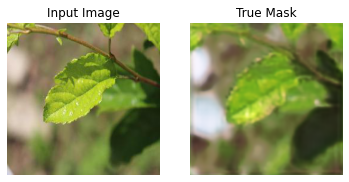


Sample Prediction after epoch 16

52/52 [==============================] - 69s 1s/step - loss: 1.1284 - outputs_loss: 0.0037 - dis_output_loss: 1.1247 - val_loss: 1.2072 - val_outputs_loss: 0.0078 - val_dis_output_loss: 1.1994
Epoch 17/100
52/52 [==============================] - 69s 1s/step - loss: 1.1218 - outputs_loss: 0.0035 - dis_output_loss: 1.1183 - val_loss: 1.1338 - val_outputs_loss: 0.0064 - val_dis_output_loss: 1.1273
Epoch 18/100
52/52 [==============================] - 69s 1s/step - loss: 1.0906 - outputs_loss: 0.0038 - dis_output_loss: 1.0867 - val_loss: 1.1330 - val_outputs_loss: 0.0086 - val_dis_output_loss: 1.1245
Epoch 19/100
52/52 [==============================] - 69s 1s/step - loss: 1.0277 - outputs_loss: 0.0039 - dis_output_loss: 1.0238 - val_loss: 5.3502 - val_outputs_loss: 0.0137 - val_dis_output_loss: 5.3366
Epoch 20/100
52/52 [==============================] - 69s 1s/step - loss: 0.9127 - outputs_loss: 0.0050 - dis_output_loss: 0.9076 - val_loss: 1.7203 - val

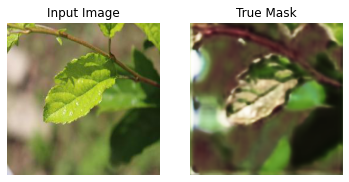


Sample Prediction after epoch 21

52/52 [==============================] - 69s 1s/step - loss: 0.8870 - outputs_loss: 0.0072 - dis_output_loss: 0.8798 - val_loss: 3.4983 - val_outputs_loss: 0.0710 - val_dis_output_loss: 3.4273
Epoch 22/100
52/52 [==============================] - 69s 1s/step - loss: 0.7337 - outputs_loss: 0.0058 - dis_output_loss: 0.7279 - val_loss: 1.4239 - val_outputs_loss: 0.0283 - val_dis_output_loss: 1.3956
Epoch 23/100
52/52 [==============================] - 69s 1s/step - loss: 0.6861 - outputs_loss: 0.0060 - dis_output_loss: 0.6801 - val_loss: 1.0004 - val_outputs_loss: 0.0251 - val_dis_output_loss: 0.9753
Epoch 24/100
52/52 [==============================] - 70s 1s/step - loss: 0.6516 - outputs_loss: 0.0063 - dis_output_loss: 0.6453 - val_loss: 1.0894 - val_outputs_loss: 0.0140 - val_dis_output_loss: 1.0754
Epoch 25/100
52/52 [==============================] - 70s 1s/step - loss: 0.6237 - outputs_loss: 0.0062 - dis_output_loss: 0.6175 - val_loss: 0.6708 - val

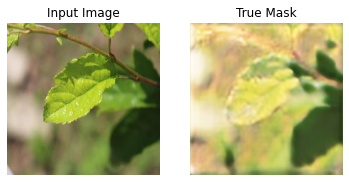


Sample Prediction after epoch 26

52/52 [==============================] - 70s 1s/step - loss: 0.4880 - outputs_loss: 0.0061 - dis_output_loss: 0.4819 - val_loss: 0.7589 - val_outputs_loss: 0.0504 - val_dis_output_loss: 0.7085
Epoch 27/100
52/52 [==============================] - 70s 1s/step - loss: 0.4359 - outputs_loss: 0.0060 - dis_output_loss: 0.4299 - val_loss: 0.8478 - val_outputs_loss: 0.0318 - val_dis_output_loss: 0.8160
Epoch 28/100
52/52 [==============================] - 70s 1s/step - loss: 0.4485 - outputs_loss: 0.0052 - dis_output_loss: 0.4432 - val_loss: 0.6748 - val_outputs_loss: 0.0191 - val_dis_output_loss: 0.6557
Epoch 29/100
52/52 [==============================] - 70s 1s/step - loss: 0.4081 - outputs_loss: 0.0051 - dis_output_loss: 0.4030 - val_loss: 0.7987 - val_outputs_loss: 0.0175 - val_dis_output_loss: 0.7811
Epoch 30/100
52/52 [==============================] - 70s 1s/step - loss: 0.3875 - outputs_loss: 0.0055 - dis_output_loss: 0.3820 - val_loss: 1.0346 - val

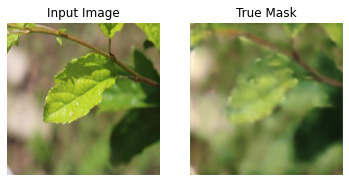


Sample Prediction after epoch 31

52/52 [==============================] - 70s 1s/step - loss: 0.3535 - outputs_loss: 0.0045 - dis_output_loss: 0.3489 - val_loss: 0.4596 - val_outputs_loss: 0.0089 - val_dis_output_loss: 0.4507
Epoch 32/100
52/52 [==============================] - 70s 1s/step - loss: 0.3315 - outputs_loss: 0.0041 - dis_output_loss: 0.3273 - val_loss: 0.4022 - val_outputs_loss: 0.0106 - val_dis_output_loss: 0.3916
Epoch 33/100
52/52 [==============================] - 69s 1s/step - loss: 0.3158 - outputs_loss: 0.0042 - dis_output_loss: 0.3116 - val_loss: 0.4964 - val_outputs_loss: 0.0078 - val_dis_output_loss: 0.4886
Epoch 34/100
52/52 [==============================] - 69s 1s/step - loss: 0.4160 - outputs_loss: 0.0063 - dis_output_loss: 0.4098 - val_loss: 0.8231 - val_outputs_loss: 0.0192 - val_dis_output_loss: 0.8040
Epoch 35/100
52/52 [==============================] - 69s 1s/step - loss: 0.3622 - outputs_loss: 0.0056 - dis_output_loss: 0.3566 - val_loss: 0.8697 - val

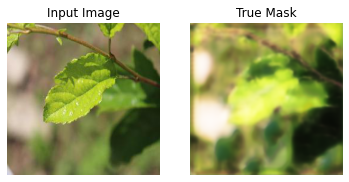


Sample Prediction after epoch 36

52/52 [==============================] - 69s 1s/step - loss: 0.3253 - outputs_loss: 0.0047 - dis_output_loss: 0.3205 - val_loss: 0.3759 - val_outputs_loss: 0.0298 - val_dis_output_loss: 0.3460
Epoch 37/100
52/52 [==============================] - 69s 1s/step - loss: 0.3155 - outputs_loss: 0.0046 - dis_output_loss: 0.3109 - val_loss: 0.4759 - val_outputs_loss: 0.0123 - val_dis_output_loss: 0.4636
Epoch 38/100
52/52 [==============================] - 69s 1s/step - loss: 0.3304 - outputs_loss: 0.0043 - dis_output_loss: 0.3261 - val_loss: 1.3452 - val_outputs_loss: 0.0186 - val_dis_output_loss: 1.3266
Epoch 39/100
52/52 [==============================] - 70s 1s/step - loss: 0.4151 - outputs_loss: 0.0050 - dis_output_loss: 0.4101 - val_loss: 1.0871 - val_outputs_loss: 0.0098 - val_dis_output_loss: 1.0773
Epoch 40/100
52/52 [==============================] - 69s 1s/step - loss: 0.3327 - outputs_loss: 0.0048 - dis_output_loss: 0.3278 - val_loss: 0.4450 - val

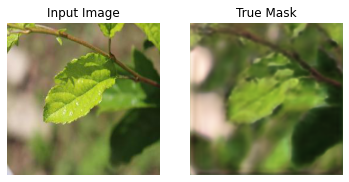


Sample Prediction after epoch 41

52/52 [==============================] - 70s 1s/step - loss: 0.3208 - outputs_loss: 0.0046 - dis_output_loss: 0.3162 - val_loss: 0.6244 - val_outputs_loss: 0.0133 - val_dis_output_loss: 0.6112
Epoch 42/100
52/52 [==============================] - 69s 1s/step - loss: 0.3693 - outputs_loss: 0.0062 - dis_output_loss: 0.3630 - val_loss: 0.7613 - val_outputs_loss: 0.0154 - val_dis_output_loss: 0.7459
Epoch 43/100
52/52 [==============================] - 69s 1s/step - loss: 0.2901 - outputs_loss: 0.0045 - dis_output_loss: 0.2855 - val_loss: 0.3792 - val_outputs_loss: 0.0105 - val_dis_output_loss: 0.3687
Epoch 44/100
52/52 [==============================] - 69s 1s/step - loss: 0.2651 - outputs_loss: 0.0039 - dis_output_loss: 0.2613 - val_loss: 0.3224 - val_outputs_loss: 0.0094 - val_dis_output_loss: 0.3130
Epoch 45/100
52/52 [==============================] - 69s 1s/step - loss: 0.2747 - outputs_loss: 0.0050 - dis_output_loss: 0.2697 - val_loss: 0.2725 - val

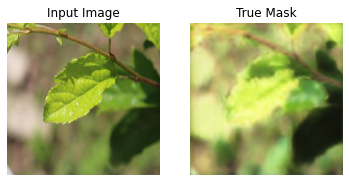


Sample Prediction after epoch 46

52/52 [==============================] - 69s 1s/step - loss: 0.2651 - outputs_loss: 0.0042 - dis_output_loss: 0.2608 - val_loss: 0.4494 - val_outputs_loss: 0.0119 - val_dis_output_loss: 0.4375
Epoch 47/100
52/52 [==============================] - 69s 1s/step - loss: 0.2331 - outputs_loss: 0.0038 - dis_output_loss: 0.2292 - val_loss: 0.3869 - val_outputs_loss: 0.0082 - val_dis_output_loss: 0.3786
Epoch 48/100
52/52 [==============================] - 69s 1s/step - loss: 0.2596 - outputs_loss: 0.0042 - dis_output_loss: 0.2554 - val_loss: 0.3894 - val_outputs_loss: 0.0151 - val_dis_output_loss: 0.3743
Epoch 49/100
52/52 [==============================] - 69s 1s/step - loss: 0.2384 - outputs_loss: 0.0037 - dis_output_loss: 0.2346 - val_loss: 0.4138 - val_outputs_loss: 0.0095 - val_dis_output_loss: 0.4043
Epoch 50/100
52/52 [==============================] - 69s 1s/step - loss: 0.2660 - outputs_loss: 0.0038 - dis_output_loss: 0.2622 - val_loss: 0.3994 - val

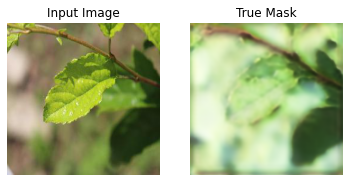


Sample Prediction after epoch 51

52/52 [==============================] - 69s 1s/step - loss: 0.4054 - outputs_loss: 0.0050 - dis_output_loss: 0.4004 - val_loss: 0.7449 - val_outputs_loss: 0.0301 - val_dis_output_loss: 0.7148
Epoch 52/100
52/52 [==============================] - 69s 1s/step - loss: 0.2962 - outputs_loss: 0.0048 - dis_output_loss: 0.2914 - val_loss: 0.3783 - val_outputs_loss: 0.0107 - val_dis_output_loss: 0.3677
Epoch 53/100
52/52 [==============================] - 69s 1s/step - loss: 0.2833 - outputs_loss: 0.0040 - dis_output_loss: 0.2793 - val_loss: 0.4874 - val_outputs_loss: 0.0197 - val_dis_output_loss: 0.4678
Epoch 54/100
52/52 [==============================] - 69s 1s/step - loss: 0.2520 - outputs_loss: 0.0038 - dis_output_loss: 0.2482 - val_loss: 0.3366 - val_outputs_loss: 0.0059 - val_dis_output_loss: 0.3308
Epoch 55/100
52/52 [==============================] - 69s 1s/step - loss: 0.2188 - outputs_loss: 0.0036 - dis_output_loss: 0.2152 - val_loss: 0.8683 - val

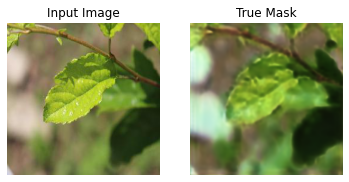


Sample Prediction after epoch 56

52/52 [==============================] - 69s 1s/step - loss: 0.2275 - outputs_loss: 0.0036 - dis_output_loss: 0.2239 - val_loss: 0.4296 - val_outputs_loss: 0.0075 - val_dis_output_loss: 0.4221
Epoch 57/100
52/52 [==============================] - 69s 1s/step - loss: 0.2449 - outputs_loss: 0.0036 - dis_output_loss: 0.2413 - val_loss: 0.7187 - val_outputs_loss: 0.0095 - val_dis_output_loss: 0.7091
Epoch 58/100
52/52 [==============================] - 69s 1s/step - loss: 0.2735 - outputs_loss: 0.0042 - dis_output_loss: 0.2694 - val_loss: 0.4765 - val_outputs_loss: 0.0134 - val_dis_output_loss: 0.4631
Epoch 59/100
52/52 [==============================] - 69s 1s/step - loss: 0.2673 - outputs_loss: 0.0045 - dis_output_loss: 0.2628 - val_loss: 0.5394 - val_outputs_loss: 0.0155 - val_dis_output_loss: 0.5239
Epoch 60/100
52/52 [==============================] - 69s 1s/step - loss: 0.2411 - outputs_loss: 0.0039 - dis_output_loss: 0.2372 - val_loss: 0.2840 - val

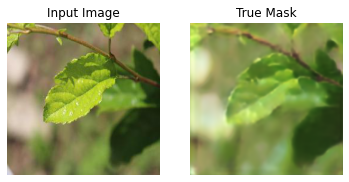


Sample Prediction after epoch 61

52/52 [==============================] - 70s 1s/step - loss: 0.2241 - outputs_loss: 0.0038 - dis_output_loss: 0.2203 - val_loss: 0.2717 - val_outputs_loss: 0.0063 - val_dis_output_loss: 0.2654
Epoch 62/100
52/52 [==============================] - 69s 1s/step - loss: 0.2062 - outputs_loss: 0.0035 - dis_output_loss: 0.2026 - val_loss: 0.2961 - val_outputs_loss: 0.0061 - val_dis_output_loss: 0.2901
Epoch 63/100
52/52 [==============================] - 69s 1s/step - loss: 0.2502 - outputs_loss: 0.0038 - dis_output_loss: 0.2464 - val_loss: 0.2762 - val_outputs_loss: 0.0073 - val_dis_output_loss: 0.2689
Epoch 64/100
52/52 [==============================] - 69s 1s/step - loss: 0.2063 - outputs_loss: 0.0035 - dis_output_loss: 0.2028 - val_loss: 0.4211 - val_outputs_loss: 0.0225 - val_dis_output_loss: 0.3986
Epoch 65/100
52/52 [==============================] - 69s 1s/step - loss: 0.2211 - outputs_loss: 0.0035 - dis_output_loss: 0.2176 - val_loss: 0.3744 - val

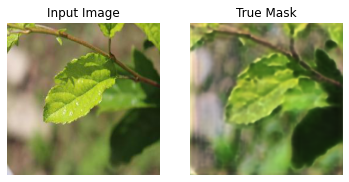


Sample Prediction after epoch 66

52/52 [==============================] - 69s 1s/step - loss: 0.2272 - outputs_loss: 0.0035 - dis_output_loss: 0.2237 - val_loss: 0.4603 - val_outputs_loss: 0.0092 - val_dis_output_loss: 0.4511
Epoch 67/100
52/52 [==============================] - 69s 1s/step - loss: 0.2120 - outputs_loss: 0.0034 - dis_output_loss: 0.2086 - val_loss: 0.3678 - val_outputs_loss: 0.0128 - val_dis_output_loss: 0.3550
Epoch 68/100
52/52 [==============================] - 69s 1s/step - loss: 0.2196 - outputs_loss: 0.0036 - dis_output_loss: 0.2160 - val_loss: 0.5745 - val_outputs_loss: 0.0137 - val_dis_output_loss: 0.5607
Epoch 69/100
52/52 [==============================] - 69s 1s/step - loss: 0.2425 - outputs_loss: 0.0035 - dis_output_loss: 0.2391 - val_loss: 0.4341 - val_outputs_loss: 0.0076 - val_dis_output_loss: 0.4264
Epoch 70/100
52/52 [==============================] - 69s 1s/step - loss: 0.2536 - outputs_loss: 0.0034 - dis_output_loss: 0.2502 - val_loss: 0.2498 - val

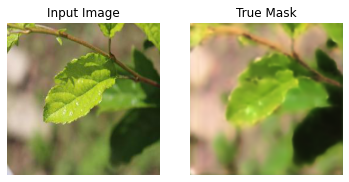


Sample Prediction after epoch 71

52/52 [==============================] - 69s 1s/step - loss: 0.2056 - outputs_loss: 0.0030 - dis_output_loss: 0.2026 - val_loss: 0.3794 - val_outputs_loss: 0.0078 - val_dis_output_loss: 0.3716
Epoch 72/100
52/52 [==============================] - 69s 1s/step - loss: 0.2163 - outputs_loss: 0.0030 - dis_output_loss: 0.2133 - val_loss: 0.2300 - val_outputs_loss: 0.0072 - val_dis_output_loss: 0.2228
Epoch 73/100
52/52 [==============================] - 69s 1s/step - loss: 0.1987 - outputs_loss: 0.0032 - dis_output_loss: 0.1955 - val_loss: 0.8889 - val_outputs_loss: 0.0078 - val_dis_output_loss: 0.8811
Epoch 74/100
52/52 [==============================] - 69s 1s/step - loss: 0.2190 - outputs_loss: 0.0040 - dis_output_loss: 0.2150 - val_loss: 0.3350 - val_outputs_loss: 0.0147 - val_dis_output_loss: 0.3203
Epoch 75/100
52/52 [==============================] - 69s 1s/step - loss: 0.2101 - outputs_loss: 0.0031 - dis_output_loss: 0.2070 - val_loss: 0.3064 - val

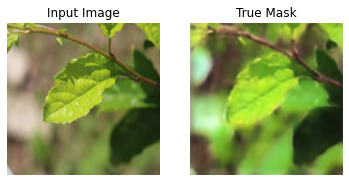


Sample Prediction after epoch 76

52/52 [==============================] - 69s 1s/step - loss: 0.2247 - outputs_loss: 0.0034 - dis_output_loss: 0.2213 - val_loss: 0.2243 - val_outputs_loss: 0.0102 - val_dis_output_loss: 0.2141
Epoch 77/100
52/52 [==============================] - 69s 1s/step - loss: 0.2387 - outputs_loss: 0.0043 - dis_output_loss: 0.2345 - val_loss: 0.9505 - val_outputs_loss: 0.0122 - val_dis_output_loss: 0.9382
Epoch 78/100
52/52 [==============================] - 69s 1s/step - loss: 0.2135 - outputs_loss: 0.0032 - dis_output_loss: 0.2103 - val_loss: 0.3557 - val_outputs_loss: 0.0228 - val_dis_output_loss: 0.3329
Epoch 79/100
52/52 [==============================] - 69s 1s/step - loss: 0.2528 - outputs_loss: 0.0044 - dis_output_loss: 0.2485 - val_loss: 0.3421 - val_outputs_loss: 0.0219 - val_dis_output_loss: 0.3202
Epoch 80/100
52/52 [==============================] - 69s 1s/step - loss: 0.2657 - outputs_loss: 0.0050 - dis_output_loss: 0.2607 - val_loss: 0.3846 - val

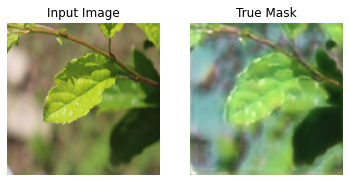


Sample Prediction after epoch 81

52/52 [==============================] - 69s 1s/step - loss: 0.2121 - outputs_loss: 0.0035 - dis_output_loss: 0.2085 - val_loss: 0.9922 - val_outputs_loss: 0.0186 - val_dis_output_loss: 0.9736
Epoch 82/100
52/52 [==============================] - 69s 1s/step - loss: 0.2323 - outputs_loss: 0.0038 - dis_output_loss: 0.2285 - val_loss: 0.4384 - val_outputs_loss: 0.0094 - val_dis_output_loss: 0.4290
Epoch 83/100
52/52 [==============================] - 69s 1s/step - loss: 0.2080 - outputs_loss: 0.0035 - dis_output_loss: 0.2045 - val_loss: 0.4913 - val_outputs_loss: 0.0096 - val_dis_output_loss: 0.4817
Epoch 84/100
52/52 [==============================] - 69s 1s/step - loss: 0.2033 - outputs_loss: 0.0032 - dis_output_loss: 0.2001 - val_loss: 0.3651 - val_outputs_loss: 0.0060 - val_dis_output_loss: 0.3591
Epoch 85/100
52/52 [==============================] - 69s 1s/step - loss: 0.1998 - outputs_loss: 0.0033 - dis_output_loss: 0.1966 - val_loss: 0.3030 - val

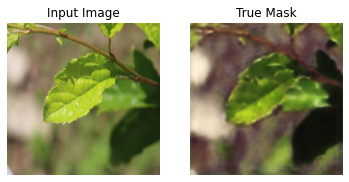


Sample Prediction after epoch 86

52/52 [==============================] - 69s 1s/step - loss: 0.2123 - outputs_loss: 0.0035 - dis_output_loss: 0.2088 - val_loss: 0.6398 - val_outputs_loss: 0.0112 - val_dis_output_loss: 0.6286
Epoch 87/100
52/52 [==============================] - 69s 1s/step - loss: 0.1890 - outputs_loss: 0.0032 - dis_output_loss: 0.1858 - val_loss: 0.5897 - val_outputs_loss: 0.0062 - val_dis_output_loss: 0.5835
Epoch 88/100
52/52 [==============================] - 69s 1s/step - loss: 0.1914 - outputs_loss: 0.0029 - dis_output_loss: 0.1885 - val_loss: 0.3654 - val_outputs_loss: 0.0066 - val_dis_output_loss: 0.3587
Epoch 89/100
52/52 [==============================] - 69s 1s/step - loss: 0.2227 - outputs_loss: 0.0034 - dis_output_loss: 0.2194 - val_loss: 0.3794 - val_outputs_loss: 0.0112 - val_dis_output_loss: 0.3682
Epoch 90/100
52/52 [==============================] - 69s 1s/step - loss: 0.1755 - outputs_loss: 0.0035 - dis_output_loss: 0.1720 - val_loss: 0.3594 - val

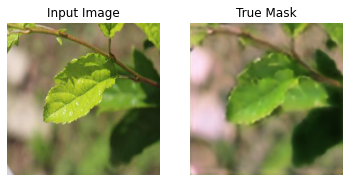


Sample Prediction after epoch 91

52/52 [==============================] - 69s 1s/step - loss: 0.1776 - outputs_loss: 0.0034 - dis_output_loss: 0.1741 - val_loss: 0.4762 - val_outputs_loss: 0.0073 - val_dis_output_loss: 0.4689
Epoch 92/100
52/52 [==============================] - 69s 1s/step - loss: 0.1590 - outputs_loss: 0.0031 - dis_output_loss: 0.1560 - val_loss: 0.2413 - val_outputs_loss: 0.0103 - val_dis_output_loss: 0.2311
Epoch 93/100
52/52 [==============================] - 69s 1s/step - loss: 0.2219 - outputs_loss: 0.0031 - dis_output_loss: 0.2188 - val_loss: 1.3123 - val_outputs_loss: 0.0148 - val_dis_output_loss: 1.2974
Epoch 94/100
52/52 [==============================] - 69s 1s/step - loss: 0.2364 - outputs_loss: 0.0037 - dis_output_loss: 0.2326 - val_loss: 0.6847 - val_outputs_loss: 0.0172 - val_dis_output_loss: 0.6675
Epoch 95/100
52/52 [==============================] - 69s 1s/step - loss: 0.1896 - outputs_loss: 0.0034 - dis_output_loss: 0.1862 - val_loss: 0.2494 - val

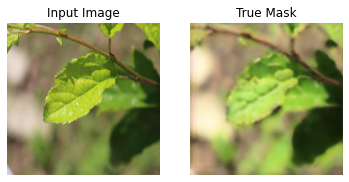


Sample Prediction after epoch 96

52/52 [==============================] - 69s 1s/step - loss: 0.2556 - outputs_loss: 0.0034 - dis_output_loss: 0.2522 - val_loss: 0.6976 - val_outputs_loss: 0.0118 - val_dis_output_loss: 0.6858
Epoch 97/100
52/52 [==============================] - 69s 1s/step - loss: 0.1476 - outputs_loss: 0.0031 - dis_output_loss: 0.1446 - val_loss: 0.3500 - val_outputs_loss: 0.0062 - val_dis_output_loss: 0.3438
Epoch 98/100
52/52 [==============================] - 69s 1s/step - loss: 0.1869 - outputs_loss: 0.0032 - dis_output_loss: 0.1837 - val_loss: 0.5219 - val_outputs_loss: 0.0128 - val_dis_output_loss: 0.5091
Epoch 99/100
52/52 [==============================] - 69s 1s/step - loss: 0.1766 - outputs_loss: 0.0032 - dis_output_loss: 0.1734 - val_loss: 0.4326 - val_outputs_loss: 0.0091 - val_dis_output_loss: 0.4235
Epoch 100/100
52/52 [==============================] - 69s 1s/step - loss: 0.2183 - outputs_loss: 0.0036 - dis_output_loss: 0.2147 - val_loss: 0.3386 - va

In [0]:
history = autoencoder.fit(
    ds,
    steps_per_epoch=len(image_generator),
    shuffle=True,
    validation_data=val_ds,
    validation_steps = len(val_image_generator),
    epochs=100,
    verbose = 1,
    callbacks=callbacks
)

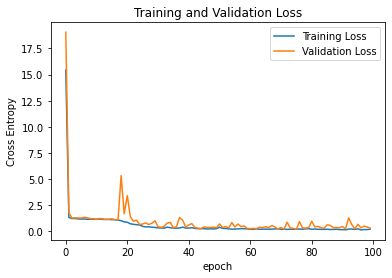

In [0]:
loss = history.history['dis_output_loss']
val_loss = history.history['val_dis_output_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
return_image = autoencoder.predict(test_images)

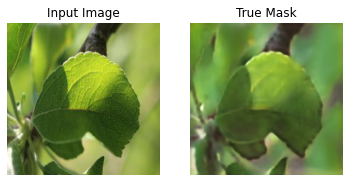

[[9.90196824e-01 4.53888485e-03 4.95074841e-04 4.76914225e-03]
 [3.94578964e-01 1.68650672e-01 3.22211459e-02 4.04549211e-01]
 [9.98943627e-01 8.85271118e-04 8.66860719e-05 8.44511305e-05]
 [9.99413133e-01 5.05228643e-04 4.10755238e-05 4.04914936e-05]
 [9.21384096e-01 4.87473942e-02 2.61865072e-02 3.68193863e-03]
 [9.99356091e-01 5.66033879e-04 5.89450246e-05 1.89518505e-05]
 [9.98245120e-01 1.47645827e-03 2.40150795e-04 3.82904218e-05]
 [9.97811854e-01 1.82127941e-03 3.13585304e-04 5.32846207e-05]
 [9.10472393e-01 3.34262140e-02 4.92375996e-03 5.11777177e-02]
 [8.62181246e-01 6.27208054e-02 7.48366714e-02 2.61293171e-04]
 [9.99122679e-01 7.55895686e-04 7.81040726e-05 4.33718269e-05]
 [9.99242783e-01 6.60045072e-04 6.92858521e-05 2.79157121e-05]
 [9.98519838e-01 1.19894953e-03 1.23123769e-04 1.58106253e-04]
 [9.93469238e-01 4.70912177e-03 7.39822921e-04 1.08180230e-03]
 [9.96013522e-01 3.13828257e-03 8.06135649e-04 4.21378354e-05]
 [9.99124944e-01 7.45580939e-04 7.14002090e-05 5.802958

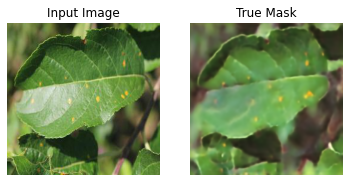

[[9.90196824e-01 4.53888485e-03 4.95074841e-04 4.76914225e-03]
 [3.94578964e-01 1.68650672e-01 3.22211459e-02 4.04549211e-01]
 [9.98943627e-01 8.85271118e-04 8.66860719e-05 8.44511305e-05]
 [9.99413133e-01 5.05228643e-04 4.10755238e-05 4.04914936e-05]
 [9.21384096e-01 4.87473942e-02 2.61865072e-02 3.68193863e-03]
 [9.99356091e-01 5.66033879e-04 5.89450246e-05 1.89518505e-05]
 [9.98245120e-01 1.47645827e-03 2.40150795e-04 3.82904218e-05]
 [9.97811854e-01 1.82127941e-03 3.13585304e-04 5.32846207e-05]
 [9.10472393e-01 3.34262140e-02 4.92375996e-03 5.11777177e-02]
 [8.62181246e-01 6.27208054e-02 7.48366714e-02 2.61293171e-04]
 [9.99122679e-01 7.55895686e-04 7.81040726e-05 4.33718269e-05]
 [9.99242783e-01 6.60045072e-04 6.92858521e-05 2.79157121e-05]
 [9.98519838e-01 1.19894953e-03 1.23123769e-04 1.58106253e-04]
 [9.93469238e-01 4.70912177e-03 7.39822921e-04 1.08180230e-03]
 [9.96013522e-01 3.13828257e-03 8.06135649e-04 4.21378354e-05]
 [9.99124944e-01 7.45580939e-04 7.14002090e-05 5.802958

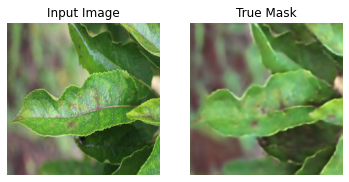

[[9.90196824e-01 4.53888485e-03 4.95074841e-04 4.76914225e-03]
 [3.94578964e-01 1.68650672e-01 3.22211459e-02 4.04549211e-01]
 [9.98943627e-01 8.85271118e-04 8.66860719e-05 8.44511305e-05]
 [9.99413133e-01 5.05228643e-04 4.10755238e-05 4.04914936e-05]
 [9.21384096e-01 4.87473942e-02 2.61865072e-02 3.68193863e-03]
 [9.99356091e-01 5.66033879e-04 5.89450246e-05 1.89518505e-05]
 [9.98245120e-01 1.47645827e-03 2.40150795e-04 3.82904218e-05]
 [9.97811854e-01 1.82127941e-03 3.13585304e-04 5.32846207e-05]
 [9.10472393e-01 3.34262140e-02 4.92375996e-03 5.11777177e-02]
 [8.62181246e-01 6.27208054e-02 7.48366714e-02 2.61293171e-04]
 [9.99122679e-01 7.55895686e-04 7.81040726e-05 4.33718269e-05]
 [9.99242783e-01 6.60045072e-04 6.92858521e-05 2.79157121e-05]
 [9.98519838e-01 1.19894953e-03 1.23123769e-04 1.58106253e-04]
 [9.93469238e-01 4.70912177e-03 7.39822921e-04 1.08180230e-03]
 [9.96013522e-01 3.13828257e-03 8.06135649e-04 4.21378354e-05]
 [9.99124944e-01 7.45580939e-04 7.14002090e-05 5.802958

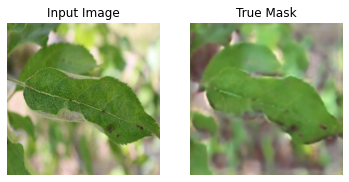

[[9.90196824e-01 4.53888485e-03 4.95074841e-04 4.76914225e-03]
 [3.94578964e-01 1.68650672e-01 3.22211459e-02 4.04549211e-01]
 [9.98943627e-01 8.85271118e-04 8.66860719e-05 8.44511305e-05]
 [9.99413133e-01 5.05228643e-04 4.10755238e-05 4.04914936e-05]
 [9.21384096e-01 4.87473942e-02 2.61865072e-02 3.68193863e-03]
 [9.99356091e-01 5.66033879e-04 5.89450246e-05 1.89518505e-05]
 [9.98245120e-01 1.47645827e-03 2.40150795e-04 3.82904218e-05]
 [9.97811854e-01 1.82127941e-03 3.13585304e-04 5.32846207e-05]
 [9.10472393e-01 3.34262140e-02 4.92375996e-03 5.11777177e-02]
 [8.62181246e-01 6.27208054e-02 7.48366714e-02 2.61293171e-04]
 [9.99122679e-01 7.55895686e-04 7.81040726e-05 4.33718269e-05]
 [9.99242783e-01 6.60045072e-04 6.92858521e-05 2.79157121e-05]
 [9.98519838e-01 1.19894953e-03 1.23123769e-04 1.58106253e-04]
 [9.93469238e-01 4.70912177e-03 7.39822921e-04 1.08180230e-03]
 [9.96013522e-01 3.13828257e-03 8.06135649e-04 4.21378354e-05]
 [9.99124944e-01 7.45580939e-04 7.14002090e-05 5.802958

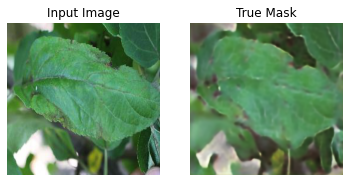

[[9.90196824e-01 4.53888485e-03 4.95074841e-04 4.76914225e-03]
 [3.94578964e-01 1.68650672e-01 3.22211459e-02 4.04549211e-01]
 [9.98943627e-01 8.85271118e-04 8.66860719e-05 8.44511305e-05]
 [9.99413133e-01 5.05228643e-04 4.10755238e-05 4.04914936e-05]
 [9.21384096e-01 4.87473942e-02 2.61865072e-02 3.68193863e-03]
 [9.99356091e-01 5.66033879e-04 5.89450246e-05 1.89518505e-05]
 [9.98245120e-01 1.47645827e-03 2.40150795e-04 3.82904218e-05]
 [9.97811854e-01 1.82127941e-03 3.13585304e-04 5.32846207e-05]
 [9.10472393e-01 3.34262140e-02 4.92375996e-03 5.11777177e-02]
 [8.62181246e-01 6.27208054e-02 7.48366714e-02 2.61293171e-04]
 [9.99122679e-01 7.55895686e-04 7.81040726e-05 4.33718269e-05]
 [9.99242783e-01 6.60045072e-04 6.92858521e-05 2.79157121e-05]
 [9.98519838e-01 1.19894953e-03 1.23123769e-04 1.58106253e-04]
 [9.93469238e-01 4.70912177e-03 7.39822921e-04 1.08180230e-03]
 [9.96013522e-01 3.13828257e-03 8.06135649e-04 4.21378354e-05]
 [9.99124944e-01 7.45580939e-04 7.14002090e-05 5.802958

<Figure size 432x288 with 0 Axes>

In [0]:
display_num = 5

r_choices = np.random.choice(test_images.shape[0], display_num)

# plt.figure(figsize=(10, 15))


for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    display([test_images[img_num],return_image[0][img_num]])
    print(return_image[1][img_num])
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
autoencoder.save('Autoencoder.hd5')

NameError: ignored

In [0]:
encoder = models.Model(inputs=[inputs], outputs=[latent])

In [0]:
return_label = encoder.predict(test_images)

In [0]:
return_label.shape

In [0]:
return_label

array([[ 102.1239  ,  -95.1952  ,  -91.153435, ...,   -9.31812 ,
         -28.847212,   99.50303 ],
       [  77.3657  ,  -70.58355 ,  -69.44128 , ...,   -9.935627,
         -19.589077,   73.185196],
       [ 114.76533 , -107.26031 , -103.11642 , ...,   -8.866317,
         -34.174805,  110.181854],
       ...,
       [  89.169426,  -81.828606,  -80.55036 , ...,  -10.908491,
         -24.21528 ,   82.37573 ],
       [ 106.621185,  -99.32745 ,  -96.64805 , ...,   -8.853313,
         -31.008791,  101.16037 ],
       [ 107.00738 ,  -98.4562  ,  -95.015236, ...,  -10.421586,
         -28.10723 ,   99.53117 ]], dtype=float32)